## Install Dependencies and Load Datasets

In [3]:
!pip install optuna

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import optuna
import lightgbm as lgb
from sklearn.inspection import permutation_importance

In [5]:
# Using CSV files with 82k rows
txn_file_id = "1iG3mFohP7A4NqjbVDHV-B917uecBlyz5"
txn_url = f"https://drive.google.com/uc?id={txn_file_id}"
txn_file = gdown.download(txn_url, quiet=False)
txn_df = pd.read_csv(txn_file)
txn_df.head()

Downloading...
From: https://drive.google.com/uc?id=1iG3mFohP7A4NqjbVDHV-B917uecBlyz5
To: /content/full_df.csv
100%|██████████| 29.5M/29.5M [00:00<00:00, 63.4MB/s]


,tx_hash,indegree,outdegree,in_btc,out_btc,total_btc,mean_in_btc,mean_out_btc,in_malicious,out_malicious,...,activity_span_days,cp_hhi_out,cp_hhi_in,peel_len,peel_ratio,pagerank,betweenness_centrality,closeness_centrality,katz_centrality,local_clustering
0,56a96d9841d22764287c9a37cedf97c47678690c2507e0...,5,2,188.74,188.74,377.48,37.748000,94.37,0,0,...,0.000000,10000.0,0.000000,1,3.740000e+08,0.000006,0.0,0.000000,0.001538,0.0
1,93d9e131c856061a11adc1054eaaf7502d147eb9e754fd...,0,1,0.00,50.00,50.00,0.000000,50.00,0,0,...,0.000000,10000.0,0.000000,2,5.000000e+09,0.000006,0.0,0.000000,0.001538,0.0
2,52093f1f0c88f21966817bc6593fcf3e2cb0c314099182...,104,1,5199.00,5199.00,10398.00,49.990385,5199.00,1,0,...,23.596343,10000.0,96.153846,1,1.000000e+00,0.000537,0.0,0.001268,0.017549,0.0
3,31d0381a230ef3c092fac8dd415cb0e02cf4f4546b03de...,0,1,0.00,50.00,50.00,0.000000,50.00,0,0,...,0.000000,10000.0,0.000000,2,5.000000e+09,0.000006,0.0,0.000000,0.001538,0.0
4,ca485d7d88cd8f82730c1530f272edf95e140d66b29f0c...,0,1,0.00,50.00,50.00,0.000000,50.00,0,0,...,0.000000,10000.0,0.000000,2,5.000000e+09,0.000006,0.0,0.000000,0.001538,0.0


## Splitting of Datasets

In [6]:
malicious_set = txn_df[txn_df['is_malicious'] == 1]
non_malicious_set = txn_df[txn_df['is_malicious'] == 0]

X_train_malicious, X_test_malicious, y_train_malicious, y_test_malicious = train_test_split( # 80-20
    malicious_set.drop(['is_malicious'], axis=1),
    malicious_set['is_malicious'],
    test_size=0.2,
    random_state=42,
)

X_train_normal, X_test_normal, y_train_normal, y_test_normal = train_test_split( # 80-20
    non_malicious_set.drop(['is_malicious'], axis=1),
    non_malicious_set['is_malicious'],
    test_size=0.2,
    random_state=42
)

X_test = pd.concat([X_test_malicious, X_test_normal])
y_test = pd.concat([y_test_malicious, y_test_normal])
X_train = pd.concat([X_train_malicious, X_train_normal])
y_train = pd.concat([y_train_malicious, y_train_normal])

print("Malicious transactions in test set:", y_test.sum())
print("Malicious transactions in training set:", y_train.sum())

Malicious transactions in test set: 10
Malicious transactions in training set: 37


## Feature Engineering

In [7]:
scaler = RobustScaler()
columns_to_drop = ['tx_hash', 'first_seen', 'last_seen', 'in_malicious', 'out_malicious', 'out_and_tx_malicious', 'all_malicious']

def feature_engineering_train(df):
  df = df.copy()
  features_to_log_scale = ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc', 'degree_sum',
                          'degree_diff', 'in_out_degree_ratio', 'in_out_btc_ratio', 'value_per_in_edge', 'value_per_out_edge',
                          'value_per_all_edges', 'tx_count', 'activity_span_seconds', 'activity_span_days', 'peel_len', 'peel_ratio',
                          'pagerank', 'betweenness_centrality', 'closeness_centrality', 'katz_centrality', 'local_clustering']
  features_to_normalize = ['cp_hhi_out', 'cp_hhi_in']

  for col in features_to_log_scale:
    df[col + '_log'] = np.log1p(df[col])

  features_to_normalize.extend([col + '_log' for col in features_to_log_scale])
  df[[c + '_norm' for c in features_to_normalize]] = scaler.fit_transform(df[features_to_normalize])

  df.drop(columns=features_to_normalize + features_to_log_scale + columns_to_drop, inplace=True)
  return df

def feature_engineering_unseen(df):
  df = df.copy()
  features_to_log_scale = ['indegree', 'outdegree', 'in_btc', 'out_btc', 'total_btc', 'mean_in_btc', 'mean_out_btc', 'degree_sum',
                          'degree_diff', 'in_out_degree_ratio', 'in_out_btc_ratio', 'value_per_in_edge', 'value_per_out_edge',
                          'value_per_all_edges', 'tx_count', 'activity_span_seconds', 'activity_span_days', 'peel_len', 'peel_ratio',
                          'pagerank', 'betweenness_centrality', 'closeness_centrality', 'katz_centrality', 'local_clustering']
  features_to_normalize = ['cp_hhi_out', 'cp_hhi_in']

  for col in features_to_log_scale:
    df[col + '_log'] = np.log1p(df[col])

  features_to_normalize.extend([col + '_log' for col in features_to_log_scale])
  df[[c + '_norm' for c in features_to_normalize]] = scaler.transform(df[features_to_normalize])

  df.drop(columns=features_to_normalize + features_to_log_scale + columns_to_drop, inplace=True, errors='ignore')
  return df

X_train = feature_engineering_train(X_train)
X_test = feature_engineering_unseen(X_test)

X_train.head()

,is_high_indegree,is_high_outdegree,is_high_total_btc,cp_hhi_out_norm,cp_hhi_in_norm,indegree_log_norm,outdegree_log_norm,in_btc_log_norm,out_btc_log_norm,total_btc_log_norm,...,tx_count_log_norm,activity_span_seconds_log_norm,activity_span_days_log_norm,peel_len_log_norm,peel_ratio_log_norm,pagerank_log_norm,betweenness_centrality_log_norm,closeness_centrality_log_norm,katz_centrality_log_norm,local_clustering_log_norm
18371,0,0,1,0.25,-0.042017,1.526456,0.0,2.236488,2.137038,1.983060,...,2.005412,1.158641,2.442495,0.0,0.000000,72.816861,0.000000,7.385746,11.526344,0.004751
16492,0,0,1,0.25,0.071429,0.609423,0.0,2.873070,2.763859,2.557984,...,0.961054,1.242112,3.322589,0.0,0.000000,499.843869,0.000009,99.003303,5.682211,0.000000
16923,0,0,1,0.75,0.928571,0.861353,0.0,2.226069,2.126779,1.973649,...,0.000000,1.074639,1.620495,1.0,0.000081,1.098403,0.000000,0.000000,0.000000,0.000000
51267,0,0,1,0.25,-0.048173,1.668643,0.0,1.759383,1.667246,1.552043,...,2.179206,1.246836,3.373377,0.0,0.000000,50.679718,0.000000,15.350533,17.396875,0.000000
36787,0,0,0,0.25,0.928571,-0.251930,0.0,1.072182,0.990585,0.930083,...,0.229638,0.568508,0.009945,0.0,0.000000,2.238612,0.000000,0.000000,0.000000,0.000000


## Machine Learning Models
The models that will be trained are:
1. Logistic Regression
2. XGBoost
3. Random Forest
4. LightGBM

### Logistic Regression

In [8]:
def objective_logistic(trial):
    C = trial.suggest_float('C', 0.01, 10.0, log=True)
    solver = trial.suggest_categorical('solver', ['liblinear', 'lbfgs'])

    params = {
        'C': C,
        'solver': solver
    }

    if solver == 'liblinear':
        params['penalty'] = trial.suggest_categorical('penalty_liblinear', ['l1', 'l2'])
        logistic_regression = LogisticRegression(**params, class_weight='balanced', max_iter=20000)
    else:
        params['penalty'] = 'l2'
        logistic_regression = LogisticRegression(**params, class_weight='balanced', max_iter=20000, n_jobs=-1)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(logistic_regression, X_train, y_train, cv=skf, scoring='roc_auc')
    return score.mean()

study_logistic = optuna.create_study(direction='maximize')
study_logistic.optimize(objective_logistic, n_trials=20)

print("Best hyperparameters found for Logistic Regression:", study_logistic.best_params)
print("Best ROC AUC score found for Logistic Regression:", study_logistic.best_value)

[I 2025-11-22 02:25:13,297] A new study created in memory with name: no-name-ce599f2e-9a31-47db-b3f0-29ac918694f2
[I 2025-11-22 02:28:04,871] Trial 0 finished with value: 0.9584370466750343 and parameters: {'C': 2.25350713796413, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.9584370466750343.
[I 2025-11-22 02:28:11,101] Trial 1 finished with value: 0.9494291039052021 and parameters: {'C': 0.025784839932900958, 'solver': 'liblinear', 'penalty_liblinear': 'l2'}. Best is trial 0 with value: 0.9584370466750343.
[I 2025-11-22 02:30:17,770] Trial 2 finished with value: 0.9558236257637971 and parameters: {'C': 2.8887978793621674, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.9584370466750343.
[I 2025-11-22 02:31:07,787] Trial 3 finished with value: 0.9481516665821241 and parameters: {'C': 0.027354283100350606, 'solver': 'lbfgs'}. Best is trial 0 with value: 0.9584370466750343.
[I 2025-11-22 02:31:27,638] Trial 4 finished with value: 0.9537003986533212 and parameters: {'C': 0.010665082

Best hyperparameters found for Logistic Regression: {'C': 2.25350713796413, 'solver': 'lbfgs'}
Best ROC AUC score found for Logistic Regression: 0.9584370466750343


In [9]:
best_params_logistic = study_logistic.best_params

if best_params_logistic['solver'] == 'liblinear':
    best_params_logistic['penalty'] = best_params_logistic.pop('penalty_liblinear')

best_logistic_regression = LogisticRegression(max_iter=20000, **best_params_logistic, class_weight='balanced')
best_logistic_regression.fit(X_train, y_train)

y_pred = (best_logistic_regression.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
y_proba = best_logistic_regression.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Logistic Regression Accuracy: {accuracy:.4f}")
print(f"Logistic Regression Precision: {precision:.4f}")
print(f"Logistic Regression Recall: {recall:.4f}")
print(f"Logistic Regression F1 Score: {f1:.4f}")
print(f"Logistic Regression ROC AUC: {roc_auc:.4f}")

Logistic Regression Accuracy: 0.9603
Logistic Regression Precision: 0.0137
Logistic Regression Recall: 0.9000
Logistic Regression F1 Score: 0.0269
Logistic Regression ROC AUC: 0.9613


### XGBoost

In [10]:
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight = neg_count / pos_count

def objective_xgb(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 0.5),
        'lambda': trial.suggest_float('lambda', 0.0, 1.0),
        'alpha': trial.suggest_float('alpha', 0.0, 1.0),
    }

    model = XGBClassifier(**params, scale_pos_weight=scale_pos_weight, random_state=42)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(objective_xgb, n_trials=20)

print("\nBest hyperparameters found for XGBoost:", study_xgb.best_params)
print("Best ROC AUC score found for XGBoost:", study_xgb.best_value)

[I 2025-11-22 03:05:59,208] A new study created in memory with name: no-name-1a1ad848-fd60-4dc9-90a2-f00be1a5ae00
[I 2025-11-22 03:06:19,068] Trial 0 finished with value: 0.9573817989758664 and parameters: {'n_estimators': 579, 'learning_rate': 0.22904162376743953, 'max_depth': 8, 'subsample': 0.7132039099898839, 'colsample_bytree': 0.8450512276621276, 'gamma': 0.15755474493748584, 'lambda': 0.8550307213213402, 'alpha': 0.5385471208249233}. Best is trial 0 with value: 0.9573817989758664.
[I 2025-11-22 03:06:29,357] Trial 1 finished with value: 0.944657506947015 and parameters: {'n_estimators': 269, 'learning_rate': 0.14163475782764515, 'max_depth': 6, 'subsample': 0.6633020139783067, 'colsample_bytree': 0.7961324961102718, 'gamma': 0.24757012367051406, 'lambda': 0.2848965256162438, 'alpha': 0.3564191837325399}. Best is trial 0 with value: 0.9573817989758664.
[I 2025-11-22 03:06:38,307] Trial 2 finished with value: 0.9640166339257199 and parameters: {'n_estimators': 245, 'learning_rate'


Best hyperparameters found for XGBoost: {'n_estimators': 464, 'learning_rate': 0.019829590870167193, 'max_depth': 8, 'subsample': 0.8936779109936623, 'colsample_bytree': 0.7877326944748915, 'gamma': 0.3673827710366912, 'lambda': 0.6841107478908514, 'alpha': 0.16182892695145956}
Best ROC AUC score found for XGBoost: 0.9745269550050623


In [11]:
best_params_xgb = study_xgb.best_params

best_xgb_model = XGBClassifier(**best_params_xgb, scale_pos_weight=scale_pos_weight, random_state=42)
best_xgb_model.fit(X_train, y_train)

y_pred_xgb = (best_xgb_model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
y_proba_xgb = best_xgb_model.predict_proba(X_test)[:, 1]

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
roc_auc_xgb = roc_auc_score(y_test, y_proba_xgb)

print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")
print(f"XGBoost Precision: {precision_xgb:.4f}")
print(f"XGBoost Recall: {recall_xgb:.4f}")
print(f"XGBoost F1 Score: {f1_xgb:.4f}")
print(f"XGBoost ROC AUC: {roc_auc_xgb:.4f}")

XGBoost Accuracy: 0.9989
XGBoost Precision: 0.1667
XGBoost Recall: 0.2000
XGBoost F1 Score: 0.1818
XGBoost ROC AUC: 0.9696


### Random Forest

In [13]:
def objective_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 5, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
    }

    model = RandomForestClassifier(**params, class_weight='balanced', random_state=42, n_jobs=-1)

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=20)

print("\nBest hyperparameters found for Random Forest:", study_rf.best_params)
print("Best ROC AUC score found for Random Forest:", study_rf.best_value)

[I 2025-11-22 03:15:42,677] A new study created in memory with name: no-name-f3f8bf03-5bf4-48ec-93d4-3faf21b048b6
[I 2025-11-22 03:17:43,401] Trial 0 finished with value: 0.9520614031652335 and parameters: {'n_estimators': 373, 'max_depth': 21, 'min_samples_split': 8, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9520614031652335.
[I 2025-11-22 03:19:06,299] Trial 1 finished with value: 0.9517234622427667 and parameters: {'n_estimators': 349, 'max_depth': 15, 'min_samples_split': 16, 'min_samples_leaf': 10, 'criterion': 'gini'}. Best is trial 0 with value: 0.9520614031652335.
[I 2025-11-22 03:20:04,795] Trial 2 finished with value: 0.9440313251255302 and parameters: {'n_estimators': 200, 'max_depth': 21, 'min_samples_split': 7, 'min_samples_leaf': 2, 'criterion': 'entropy'}. Best is trial 0 with value: 0.9520614031652335.
[I 2025-11-22 03:23:38,628] Trial 3 finished with value: 0.9663362178208967 and parameters: {'n_estimators': 868, 'max_depth': 16, 'mi


Best hyperparameters found for Random Forest: {'n_estimators': 832, 'max_depth': 14, 'min_samples_split': 12, 'min_samples_leaf': 2, 'criterion': 'entropy'}
Best ROC AUC score found for Random Forest: 0.9676316270037688


In [14]:
best_params_rf = study_rf.best_params

best_rf_model = RandomForestClassifier(**best_params_rf, class_weight='balanced', random_state=42, n_jobs=-1)
best_rf_model.fit(X_train, y_train)

y_pred_rf = (best_rf_model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
y_proba_rf = best_rf_model.predict_proba(X_test)[:, 1]

accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_proba_rf)

print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print(f"Random Forest Precision: {precision_rf:.4f}")
print(f"Random Forest Recall: {recall_rf:.4f}")
print(f"Random Forest F1 Score: {f1_rf:.4f}")
print(f"Random Forest ROC AUC: {roc_auc_rf:.4f}")

Random Forest Accuracy: 0.9993
Random Forest Precision: 0.2500
Random Forest Recall: 0.1000
Random Forest F1 Score: 0.1429
Random Forest ROC AUC: 0.7837


### LightGBM

In [15]:
# Compute class weight for positive class to handle imbalance
pos_count = (y_train == 1).sum()
neg_count = (y_train == 0).sum()
scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1.0
print(f"scale_pos_weight (neg/pos): {scale_pos_weight:.2f}")

def objective(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 15, 255),
        'max_depth': trial.suggest_int('max_depth', -1, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),

        'objective': 'binary',
        'random_state': 42,
        'n_jobs': -1,
        'scale_pos_weight': scale_pos_weight,
        'verbosity': -1
    }

    model = lgb.LGBMClassifier(**params)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best hyperparameters found for LightGBM:", study.best_params)
print("Best ROC-AUC score found for LightGBM:", study.best_value)


[I 2025-11-22 04:08:08,050] A new study created in memory with name: no-name-a52a28fa-0328-4b37-8f72-66881a51d03a


scale_pos_weight (neg/pos): 1772.27


[I 2025-11-22 04:09:26,970] Trial 0 finished with value: 0.7457495679236605 and parameters: {'num_leaves': 104, 'max_depth': 11, 'learning_rate': 0.01420528625619184, 'n_estimators': 884, 'min_child_samples': 79, 'subsample': 0.7408679847733981, 'colsample_bytree': 0.7633747762478034, 'reg_alpha': 0.0003981475372044486, 'reg_lambda': 1.1732867685799197e-08}. Best is trial 0 with value: 0.7457495679236605.
[I 2025-11-22 04:09:43,760] Trial 1 finished with value: 0.7314801090680654 and parameters: {'num_leaves': 80, 'max_depth': 6, 'learning_rate': 0.14248057684171564, 'n_estimators': 373, 'min_child_samples': 77, 'subsample': 0.6073591200650162, 'colsample_bytree': 0.8159582554171835, 'reg_alpha': 2.3368182665026473e-06, 'reg_lambda': 2.648352140355005e-05}. Best is trial 0 with value: 0.7457495679236605.
[I 2025-11-22 04:10:01,620] Trial 2 finished with value: 0.6711245892070689 and parameters: {'num_leaves': 121, 'max_depth': 11, 'learning_rate': 0.06544610837888805, 'n_estimators': 1

Best hyperparameters found for LightGBM: {'num_leaves': 50, 'max_depth': 3, 'learning_rate': 0.1182303061350405, 'n_estimators': 702, 'min_child_samples': 7, 'subsample': 0.8300695141102323, 'colsample_bytree': 0.6204891422410764, 'reg_alpha': 0.07079377290885588, 'reg_lambda': 0.015359775228099075}
Best ROC-AUC score found for LightGBM: 0.8486038945162935


In [16]:
# Make predictions on test set using best LightGBM model
best_params = study.best_params

best_params.update({
    'objective': 'binary',
    'random_state': 42,
    'n_jobs': -1,
    'scale_pos_weight': scale_pos_weight,
    'verbosity': -1
})

best_lgbm = lgb.LGBMClassifier(**best_params)
best_lgbm.fit(X_train, y_train)

# Probabilities and class predictions
y_proba_lgb = best_lgbm.predict_proba(X_test)[:, 1]
y_pred_lgb = (y_proba_lgb >= 0.5).astype(int)

accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
precision_lgb = precision_score(y_test, y_pred_lgb, zero_division=0)
recall_lgb = recall_score(y_test, y_pred_lgb, zero_division=0)
f1_lgb = f1_score(y_test, y_pred_lgb, zero_division=0)
roc_auc_lgb = roc_auc_score(y_test, y_proba_lgb)

print(f"LightGBM Accuracy: {accuracy_lgb:.4f}")
print(f"LightGBM Precision: {precision_lgb:.4f}")
print(f"LightGBM Recall: {recall_lgb:.4f}")
print(f"LightGBM F1 Score: {f1_lgb:.4f}")
print(f"LightGBM ROC AUC: {roc_auc_lgb:.4f}")

LightGBM Accuracy: 0.8966
LightGBM Precision: 0.0047
LightGBM Recall: 0.8000
LightGBM F1 Score: 0.0093
LightGBM ROC AUC: 0.8081


## Feature Importance for Tabular Models

In [17]:
X_test_importance = X_test.copy()
y_test_importance = y_test.copy()

### Logistic Regression

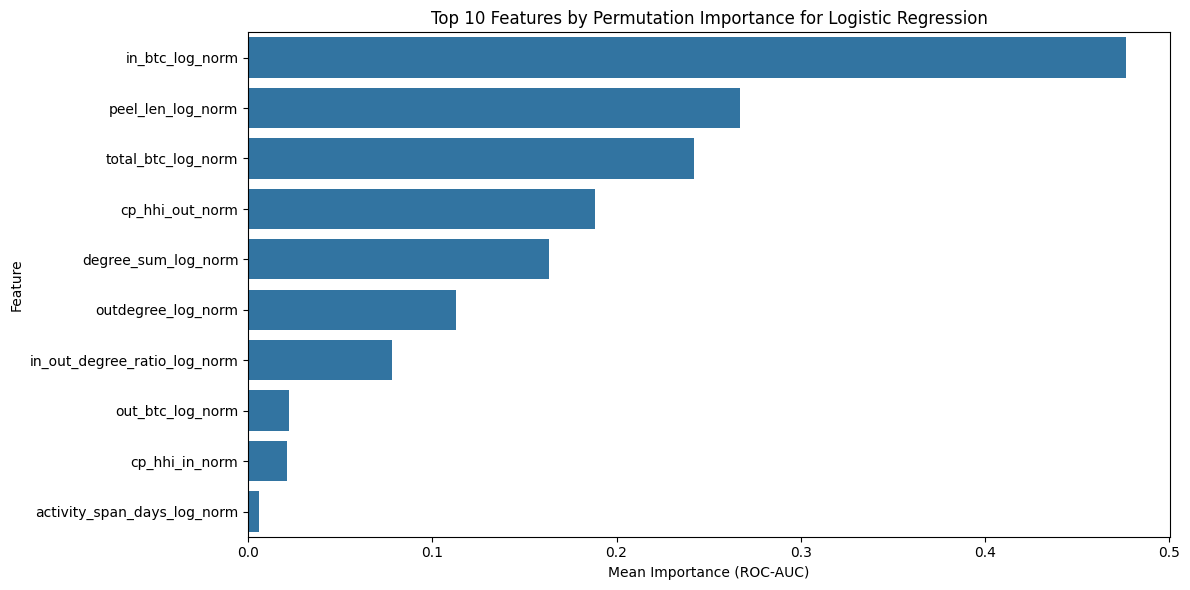

In [18]:
result = permutation_importance(
    best_logistic_regression,
    X_test_importance,
    y_test_importance,
    scoring='roc_auc',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

feature_importances = pd.DataFrame({
    'feature': X_test_importance.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
})

# Sort by importance and display top 10
feature_importances = feature_importances.sort_values(by='importance_mean', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='importance_mean', y='feature', data=feature_importances.head(10))
plt.title('Top 10 Features by Permutation Importance for Logistic Regression')
plt.xlabel('Mean Importance (ROC-AUC)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### XGBoost

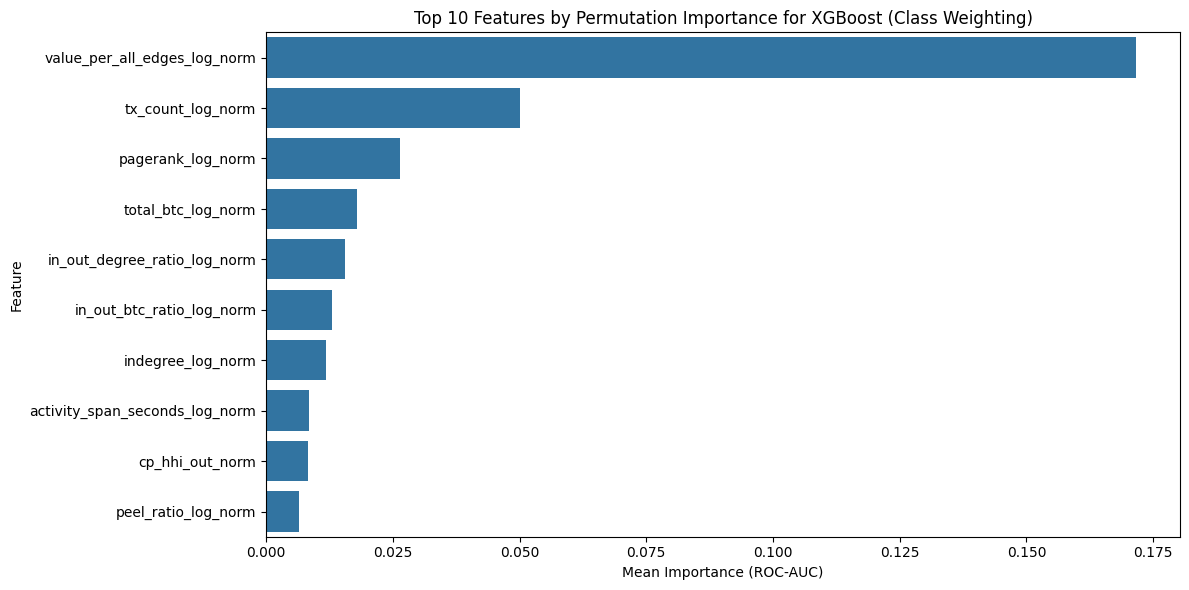

In [19]:
result = permutation_importance(
    best_xgb_model,
    X_test_importance,
    y_test_importance,
    scoring='roc_auc',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

feature_importances = pd.DataFrame({
    'feature': X_test_importance.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
})

# Sort by importance and display top 10
feature_importances = feature_importances.sort_values(by='importance_mean', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='importance_mean', y='feature', data=feature_importances.head(10))
plt.title('Top 10 Features by Permutation Importance for XGBoost (Class Weighting)')
plt.xlabel('Mean Importance (ROC-AUC)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Random Forest

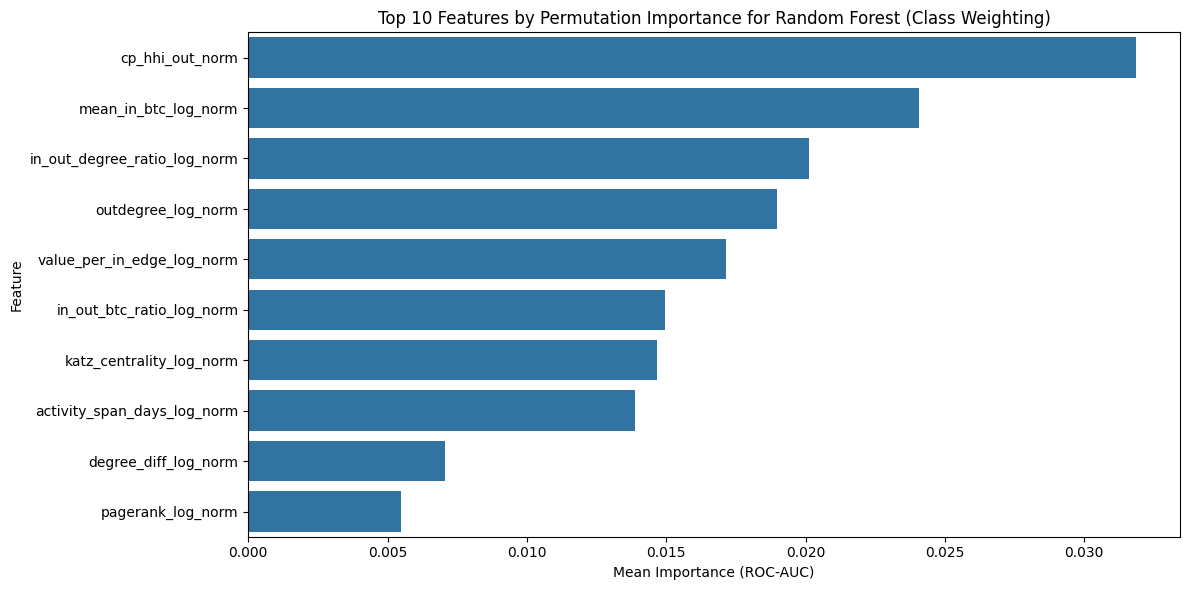

In [20]:
result = permutation_importance(
    best_rf_model,
    X_test_importance,
    y_test_importance,
    scoring='roc_auc',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

feature_importances = pd.DataFrame({
    'feature': X_test_importance.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
})

# Sort by importance and display top 10
feature_importances = feature_importances.sort_values(by='importance_mean', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='importance_mean', y='feature', data=feature_importances.head(10))
plt.title('Top 10 Features by Permutation Importance for Random Forest (Class Weighting)')
plt.xlabel('Mean Importance (ROC-AUC)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### LightGBM

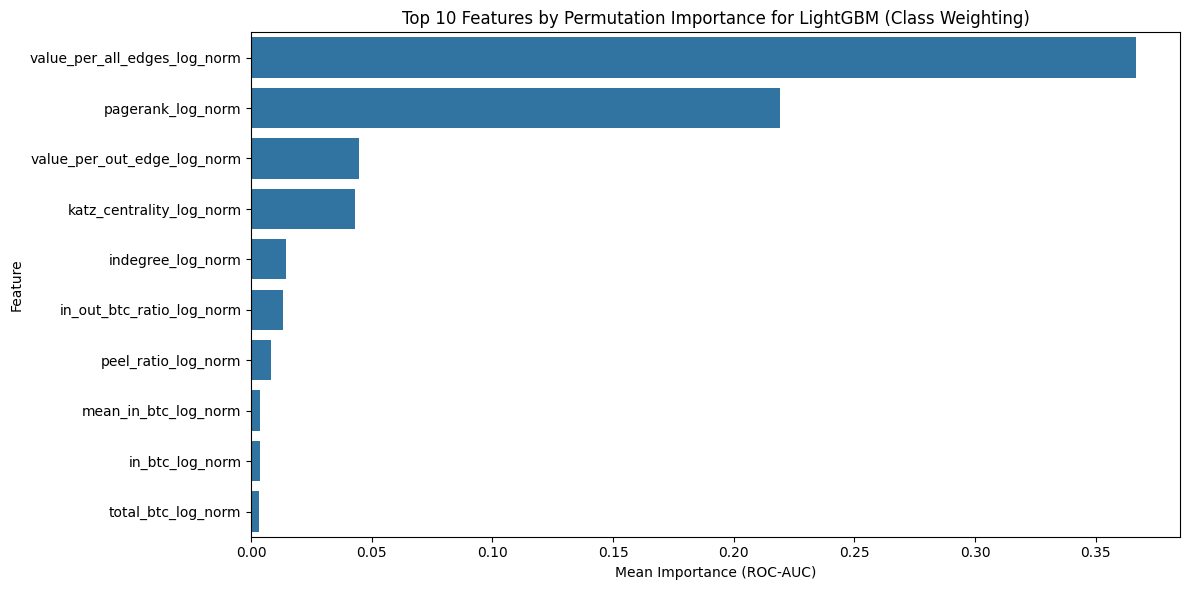

In [21]:
result = permutation_importance(
    best_lgbm,
    X_test_importance,
    y_test_importance,
    scoring='roc_auc',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

feature_importances = pd.DataFrame({
    'feature': X_test_importance.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
})

# Sort by importance and display top 10
feature_importances = feature_importances.sort_values(by='importance_mean', ascending=False)
plt.figure(figsize=(12, 6))
sns.barplot(x='importance_mean', y='feature', data=feature_importances.head(10))
plt.title('Top 10 Features by Permutation Importance for LightGBM (Class Weighting)')
plt.xlabel('Mean Importance (ROC-AUC)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()